# Detección facial utilizando tensorflow, keras y MobileNet

Por ahora se trabajará solamente con detección facial, no identificación ni comparación.

In [31]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')
faces_path='/content/gdrive/My Drive/Colab Notebooks/face_detection/faces_examples'
mobile_net_graph='/content/gdrive/My Drive/Colab Notebooks/face_detection/mobilenet/frozen_inference_graph_face.pb'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Implementación de MobileNet

Modelo basado en una mobilenet SSD (single shot multibox detector), contiene la arquitectura, las capas y los pesos. Está construida con la API de [detección de objetos de tensorflow](https://github.com/tensorflow/models/tree/master/research/object_detection) y entrenada con el dataset [WIDERFACE](http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/).



In [32]:
with tf.io.gfile.GFile(mobile_net_graph, 'rb') as f: 
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def, name='')

print(mobilenet)

# Obtener imágenes con OpenCV

In [33]:
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

# Detección de rostros

In [34]:
def detect_faces(image, score_threshold=0.2):
    global boxes, scores
    (imh, imw) = image.shape[:-1] # Incluye todos los pixeles
    img = np.expand_dims(image, axis=0)

    sess = tf.compat.v1.Session(graph=mobilenet) # Iniciar MobileNet
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')

    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img}) # Predicción de la posición del rostro (Detección)

    boxes = np.squeeze(boxes, axis=0) # Reajuste de tamaño ya que la sesión de mobilenet devuelve valores con otras dimensiones
    scores = np.squeeze(scores, axis=0)

    idx = np.where(scores>=score_threshold)[0] # Obtener solo los resultados con el umbral requerido

    bboxes = []
    for i in idx: # Creación de los bounding boxes
        ymin, xmin, ymax, xmax = boxes[i, :]
        (l, r, t, b) = (int(xmin*imw) , int(xmax*imw), int(ymin*imh), int(ymax*imh))
        bboxes.append([l, r, t, b])
    
    return bboxes


El `score_threshold=0.7` corresponde al umbral de detección de los bounding boxes de los rostros, entre menor sea, más índice de error, por lo tanto se escoge `0.7` para aumentar la exactitud.

Con `img = np.expand_dims(image, axis=0)` se agrega una dimensión para ajustar la imagen al tamaño que requiere mobilenet. Esto se hace para indicar el número de imágenes que se van a agregar y que sea una sola, ya que mobilenet trabaja normalmente con muchas imágenes simultáneamente.

# Presentando los bounding boxes

In [35]:
def draw_box(image, box, color, line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image, (box[0],box[2]), (box[1], box[3]), color, line_width) # Se pasan las coordenadas de la esquina superior izquierda y la inferior derecha
    return image

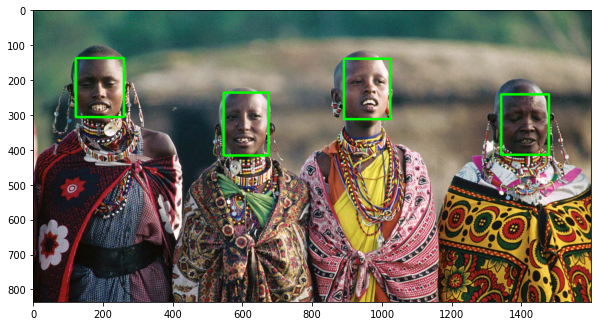

In [36]:
name = 'Women-clothing-Kenya-East-Africa.jpg'
image = load_image(faces_path, name)
bboxes = detect_faces(image)

for box in bboxes:
    detected_faces = draw_box(image, box, (0,255,0))

fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)